In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import lr_utils
import scipy
from scipy import ndimage
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
def initialize_parameters(n_x,n_h,n_y):
    """
    此函数是为了初始化两层网络参数而使用的函数。
    参数：
        n_x - 输入层节点数量
        n_h - 隐藏层节点数量
        n_y - 输出层节点数量

    返回：
        parameters - 包含你的参数的python字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    #使用断言确保我的数据格式是正确的
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters  

In [4]:
print("==============测试initialize_parameters==============")
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

==============测试initialize_parameters==============
W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[ 0.]]


In [5]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表

    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)

    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #确保我要的数据的格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))

    return parameters

In [6]:
#测试initialize_parameters_deep
print("==============测试initialize_parameters_deep==============")
layers_dims = [5,4,3]
parameters = initialize_parameters_deep(layers_dims)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

==============测试initialize_parameters_deep==============
W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


In [7]:
def linear_forward(A,W,b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)

    return Z,cache

In [8]:
#测试linear_forward
print("==============测试linear_forward==============")
A,W,b = testCases.linear_forward_test_case()
Z,linear_cache = linear_forward(A,W,b)
print("Z = " + str(Z))

==============测试linear_forward==============
Z = [[ 3.26295337 -1.23429987]]


In [9]:
def linear_activation_forward(A_prev,W,b,activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache,activation_cache)

    return A,cache

In [10]:
#测试linear_activation_forward
print("==============测试linear_activation_forward==============")
A_prev, W,b = testCases.linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("sigmoid，A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("ReLU，A = " + str(A))

==============测试linear_activation_forward==============
sigmoid，A = [[ 0.96890023  0.11013289]]
ReLU，A = [[ 3.43896131  0.        ]]


In [11]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION

    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出

    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL,caches

In [12]:
#测试L_model_forward
print("==============测试L_model_forward==============")
X,parameters = testCases.L_model_forward_test_case()
AL,caches = L_model_forward(X,parameters)
print("AL = " + str(AL))
print("caches 的长度为 = " + str(len(caches)))

==============测试L_model_forward==============
AL = [[ 0.17007265  0.2524272 ]]
caches 的长度为 = 2


In [13]:
def compute_cost(AL,Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

In [14]:
#测试compute_cost
print("==============测试compute_cost==============")
Y,AL = testCases.compute_cost_test_case()
print("cost = " + str(compute_cost(AL, Y)))

==============测试compute_cost==============
cost = 0.414931599615


In [15]:
def linear_backward(dZ,cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [16]:
#测试linear_backward
print("==============测试linear_backward==============")
dZ, linear_cache = testCases.linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

==============测试linear_backward==============
dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[ 0.50629448]]


In [17]:
def linear_activation_backward(dA,cache,activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。

    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev,dW,db

In [18]:
#测试linear_activation_backward
print("==============测试linear_activation_backward==============")
AL, linear_activation_cache = testCases.linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

==============测试linear_activation_backward==============
sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [19]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播

    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [20]:
#测试L_model_backward
print("==============测试L_model_backward==============")
AL, Y_assess, caches = testCases.L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

==============测试L_model_backward==============
dW1 = [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


In [21]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数

    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出

    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2 #整除
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [22]:
#测试update_parameters
print("==============测试update_parameters==============")
parameters, grads = testCases.update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

==============测试update_parameters==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [23]:
def two_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims

    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    """
    开始进行迭代
    """
    for i in range(0,num_iterations):
        #前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        #计算成本
        cost = compute_cost(A2,Y)

        #后向传播
        ##初始化后向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        ##向后传播，输入：“dA2，cache2，cache1”。 输出：“dA1，dW2，db2;还有dA0（未使用），dW1，db1”。
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        #更新参数
        parameters = update_parameters(parameters,grads,learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    #返回parameters
    return parameters

In [24]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

第 0 次迭代，成本值为： 0.69304973566
第 100 次迭代，成本值为： 0.646432095343
第 200 次迭代，成本值为： 0.632514064791
第 300 次迭代，成本值为： 0.601502492035
第 400 次迭代，成本值为： 0.560196631161
第 500 次迭代，成本值为： 0.515830477276
第 600 次迭代，成本值为： 0.475490131394
第 700 次迭代，成本值为： 0.433916315123
第 800 次迭代，成本值为： 0.40079775362
第 900 次迭代，成本值为： 0.358070501132
第 1000 次迭代，成本值为： 0.339428153837
第 1100 次迭代，成本值为： 0.30527536362
第 1200 次迭代，成本值为： 0.274913772821
第 1300 次迭代，成本值为： 0.246817682106
第 1400 次迭代，成本值为： 0.198507350375
第 1500 次迭代，成本值为： 0.174483181126
第 1600 次迭代，成本值为： 0.170807629781
第 1700 次迭代，成本值为： 0.113065245622
第 1800 次迭代，成本值为： 0.0962942684594
第 1900 次迭代，成本值为： 0.0834261795973
第 2000 次迭代，成本值为： 0.0743907870432
第 2100 次迭代，成本值为： 0.0663074813227
第 2200 次迭代，成本值为： 0.0591932950104
第 2300 次迭代，成本值为： 0.0533614034856
第 2400 次迭代，成本值为： 0.0485547856288


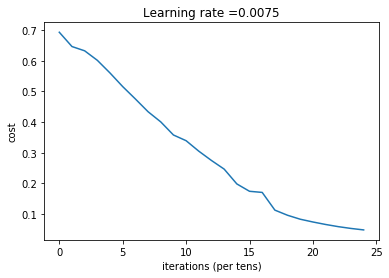

In [25]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)

In [26]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))

    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: "  + str(float(np.sum((p == y))/m)))

    return p

In [27]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确度为: 1.0
准确度为: 0.72


In [28]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。

    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱

    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)

        cost = compute_cost(AL,Y)

        grads = L_model_backward(AL,Y,caches)

        parameters = update_parameters(parameters,grads,learning_rate)

        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

In [29]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

第 0 次迭代，成本值为： 0.715731513414
第 100 次迭代，成本值为： 0.674737759347
第 200 次迭代，成本值为： 0.660336543362
第 300 次迭代，成本值为： 0.646288780215
第 400 次迭代，成本值为： 0.629813121693
第 500 次迭代，成本值为： 0.606005622927
第 600 次迭代，成本值为： 0.569004126398
第 700 次迭代，成本值为： 0.519796535044
第 800 次迭代，成本值为： 0.464157167863
第 900 次迭代，成本值为： 0.408420300483
第 1000 次迭代，成本值为： 0.373154992161
第 1100 次迭代，成本值为： 0.30572374573
第 1200 次迭代，成本值为： 0.268101528477
第 1300 次迭代，成本值为： 0.238724748277
第 1400 次迭代，成本值为： 0.206322632579
第 1500 次迭代，成本值为： 0.179438869275
第 1600 次迭代，成本值为： 0.157987358188
第 1700 次迭代，成本值为： 0.142404130123
第 1800 次迭代，成本值为： 0.128651659979
第 1900 次迭代，成本值为： 0.112443149982
第 2000 次迭代，成本值为： 0.0850563103497
第 2100 次迭代，成本值为： 0.0575839119861
第 2200 次迭代，成本值为： 0.0445675345469
第 2300 次迭代，成本值为： 0.038082751666
第 2400 次迭代，成本值为： 0.0344107490184


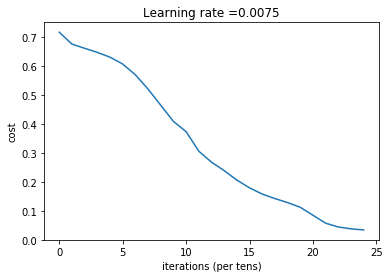

In [30]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

In [31]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为: 0.9952153110047847
准确度为: 0.78


[[ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.
   1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.
   0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  0.  0.]]
[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0
  1 0 0 1 1 1 0 0 0 1 1 1 0]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 5  6 13 19 28 29 34 44 45 46 48]]


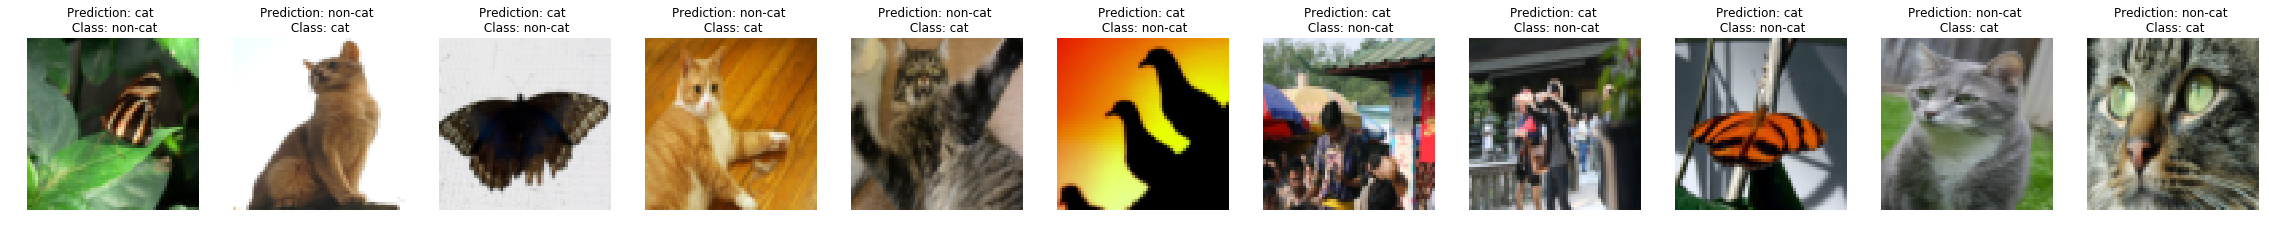

In [35]:
def print_mislabeled_images(classes, X, y, p):
    """
    绘制预测和实际不同的图像。
        X - 数据集
        y - 实际的标签
        p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    print(p)
    print(y)
    print(mislabeled_indices)
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)

准确度为: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


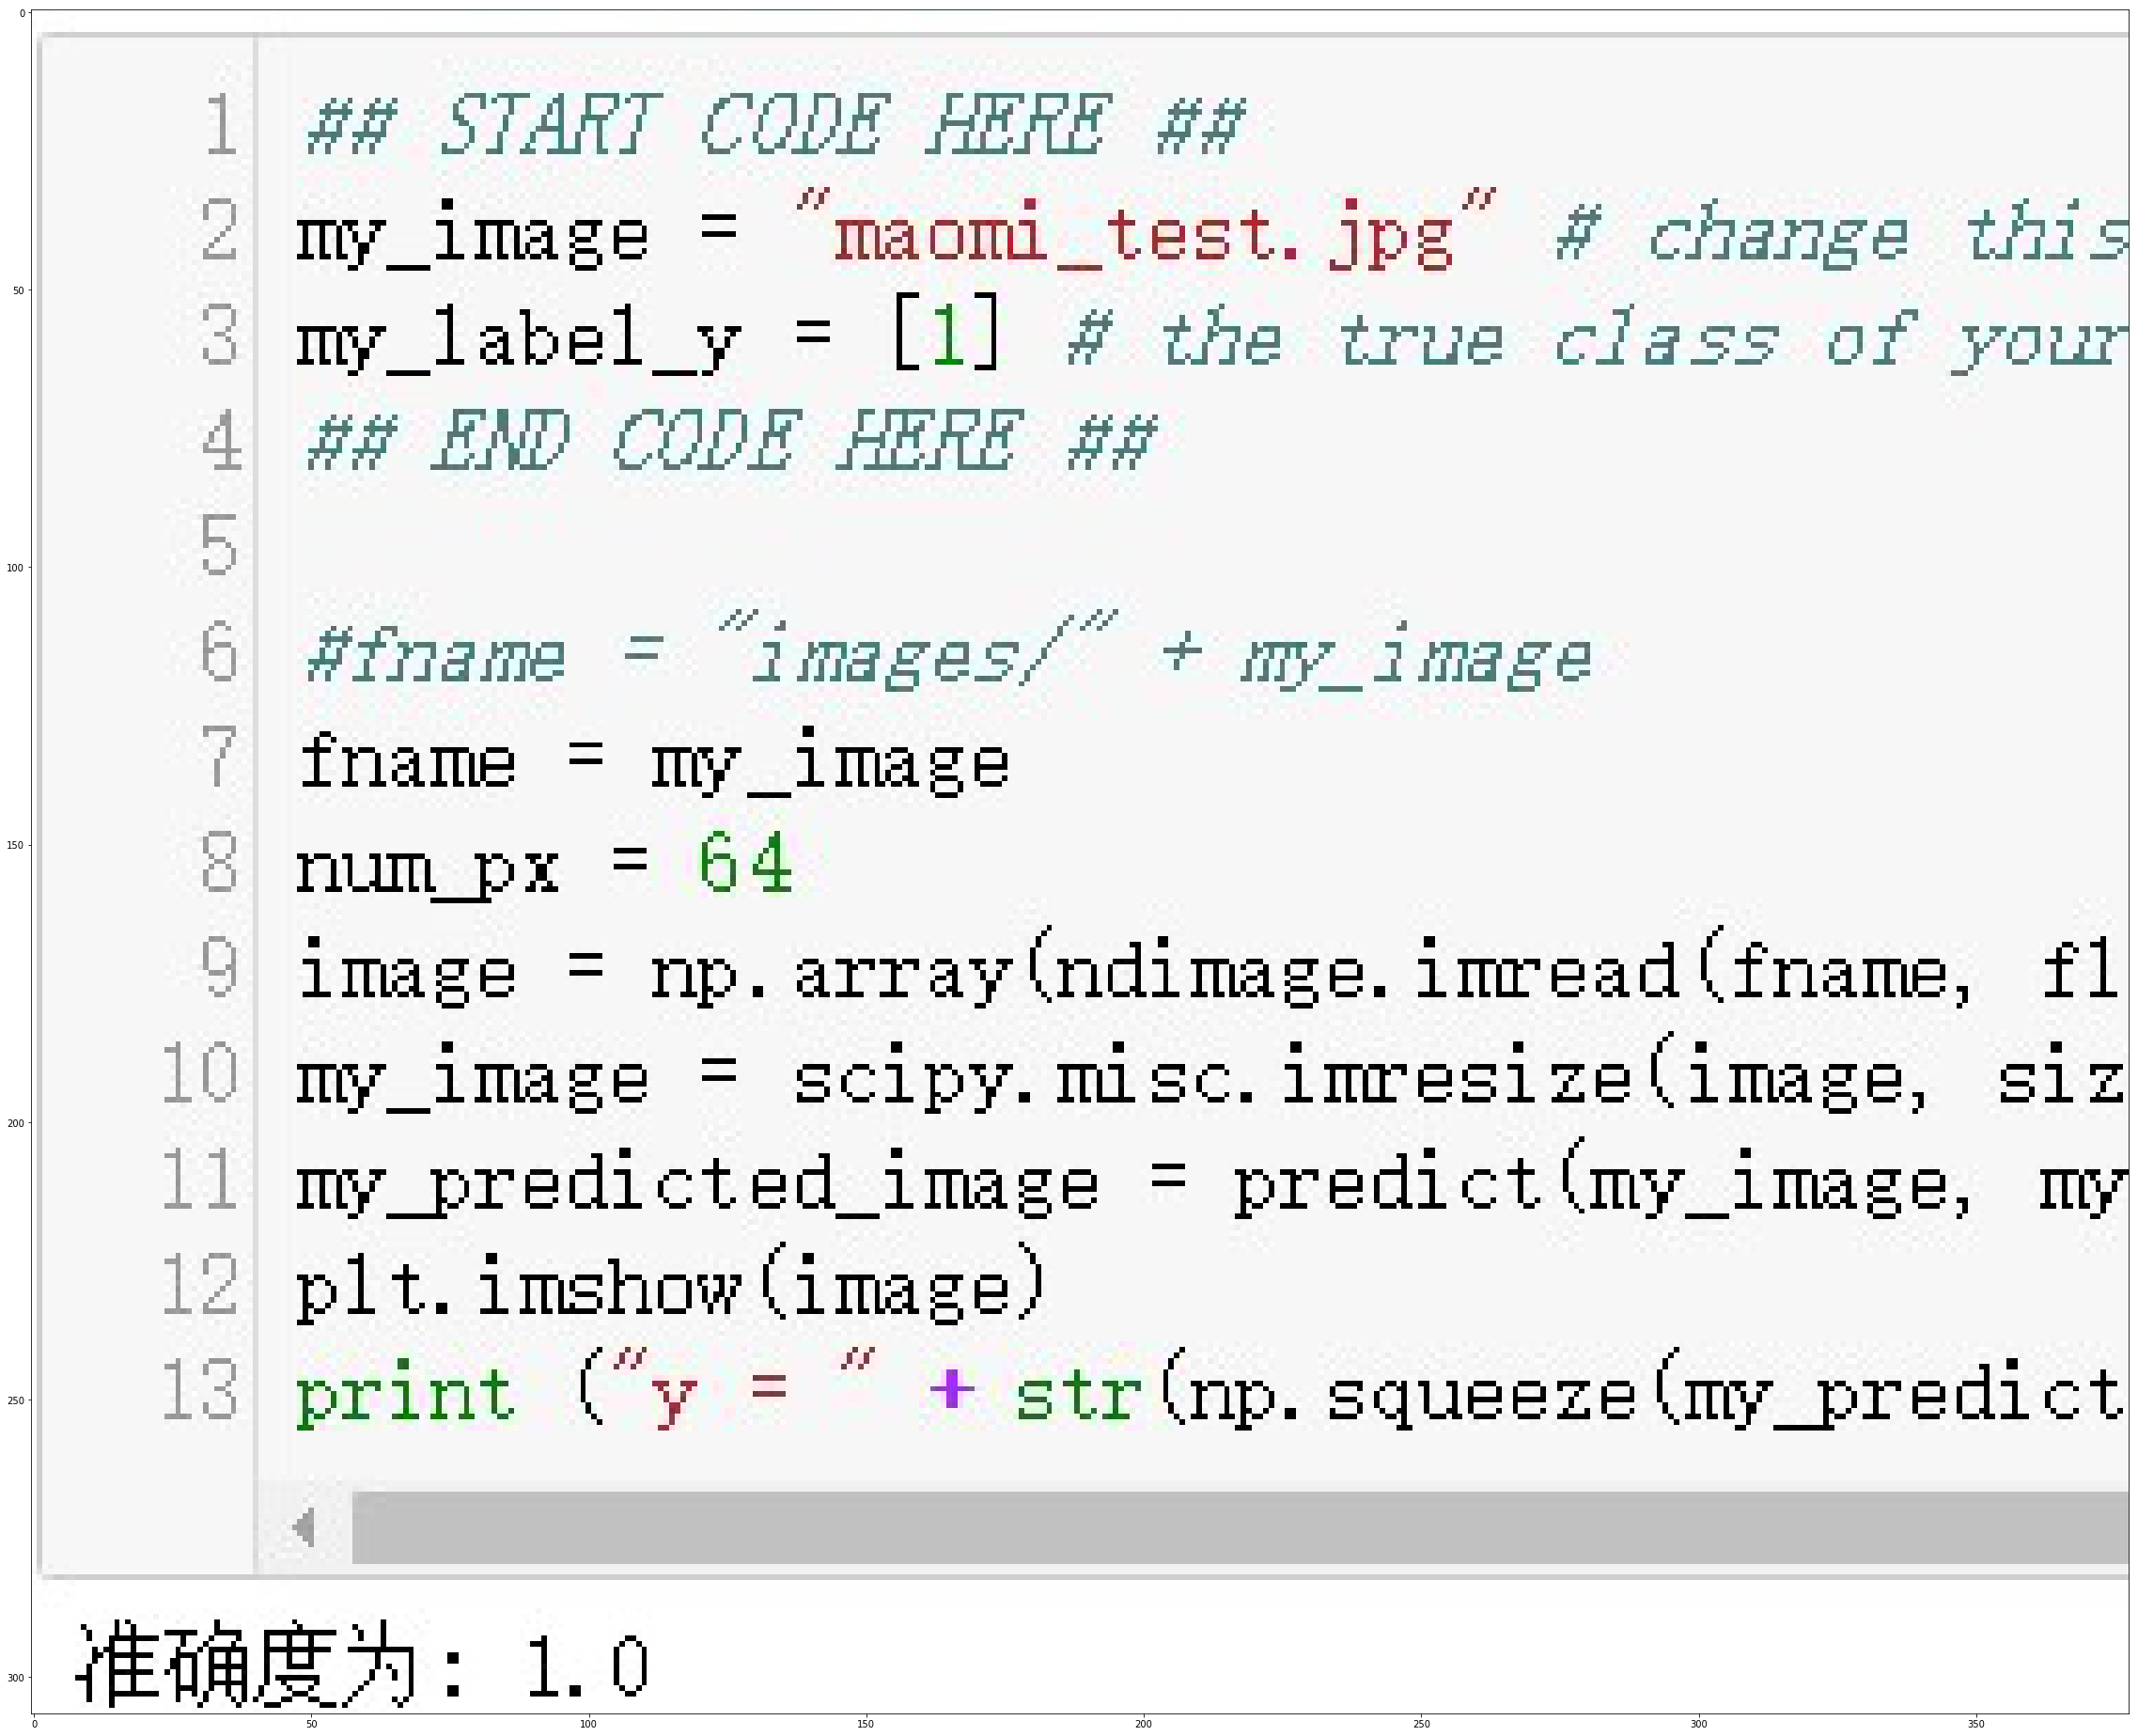

In [33]:
## START CODE HERE ##
my_image = "wenben_test.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

#fname = "images/" + my_image
fname = my_image
num_px = 64
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")